In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from scipy import stats
import time
import pandas as pd
import os


In [2]:
# ==================== 1. 初始化设置 ====================
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
np.random.seed(42)  # 固定随机种子

In [3]:
# ==================== 2. 真实数据加载 ====================
def load_real_data(file_path, hoop_pos=None):
    """
    从CSV文件加载真实数据集
    数据格式要求: 
        - 至少包含 'x', 'y', 'rpm' 三列
        - 可选: 'hoop_x', 'hoop_y' 指定篮筐位置
    """
    try:
        # 尝试读取CSV文件
        df = pd.read_csv(file_path)
        print(f"成功加载数据: {os.path.basename(file_path)}")
        print(f"样本数量: {len(df)}")
        
        # 提取坐标和转速数据
        X = df[['x', 'y']].values
        Y = df['rpm'].values
        
        # 确定篮筐位置
        if hoop_pos is not None:
            # 使用用户指定的篮筐位置
            hoop_position = np.array(hoop_pos)
            print(f"使用指定的篮筐位置: ({hoop_position[0]}, {hoop_position[1]})")
        elif 'hoop_x' in df.columns and 'hoop_y' in df.columns:
            # 从数据中获取篮筐位置
            hoop_position = np.array([df['hoop_x'].iloc[0], df['hoop_y'].iloc[0]])
            print(f"从数据中获取篮筐位置: ({hoop_position[0]}, {hoop_position[1]})")
        else:
            # 默认篮筐位置
            hoop_position = np.array([3.0, 2.0])
            print(f"使用默认篮筐位置: ({hoop_position[0]}, {hoop_position[1]})")
        
        return X, Y, hoop_position
    
    except Exception as e:
        print(f"数据加载错误: {str(e)}")
        print("请检查数据文件路径和格式")
        raise

# 真实数据文件路径 (修改为你的实际文件路径)
DATA_PATH = "basketball_shot_data.csv"  # 替换为你的数据文件路径

# 加载真实数据 (可选的篮筐位置参数)
X, Y, HOOP_POS = load_real_data(DATA_PATH)  # hoop_pos=[3.0, 2.0] 如果需要指定
print(f"数据范围: X=[{X[:,0].min():.2f}-{X[:,0].max():.2f}], "
      f"Y=[{X[:,1].min():.2f}-{X[:,1].max():.2f}], "
      f"RPM=[{Y.min():.0f}-{Y.max():.0f}]")

成功加载数据: basketball_shot_data.csv
样本数量: 50
从数据中获取篮筐位置: (3.0, 2.0)
数据范围: X=[0.52-3.49], Y=[0.53-2.45], RPM=[979-2006]



异常值处理:
  原始样本数: 50
  检测到异常值: 1个
  清洁数据集: 49个样本


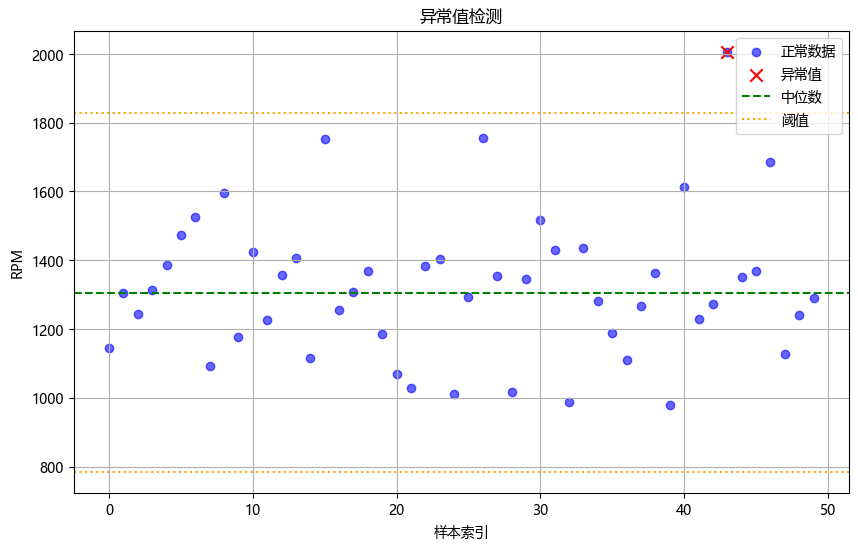

In [4]:
# ==================== 3. 异常值处理 ====================
def detect_outliers(X, Y, z_threshold=3.5):
    """使用稳健的Z-Score检测并处理异常值"""
    # 使用中位数和MAD（中位数绝对偏差）替代均值和标准差
    median = np.median(Y)
    mad = stats.median_abs_deviation(Y)
    
    # 计算稳健的Z分数
    modified_z_scores = 0.6745 * (Y - median) / mad
    
    outlier_mask = np.abs(modified_z_scores) > z_threshold
    X_clean = X[~outlier_mask]
    Y_clean = Y[~outlier_mask]
    
    print(f"\n异常值处理:")
    print(f"  原始样本数: {len(X)}")
    print(f"  检测到异常值: {np.sum(outlier_mask)}个")
    print(f"  清洁数据集: {len(X_clean)}个样本")
    
    # 可视化异常值检测
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(Y)), Y, c='blue', alpha=0.6, label='正常数据')
    plt.scatter(np.where(outlier_mask)[0], Y[outlier_mask], 
                c='red', marker='x', s=80, label='异常值')
    plt.axhline(median, color='green', linestyle='--', label='中位数')
    plt.axhline(median + 3*mad/0.6745, color='orange', linestyle=':', label='阈值')
    plt.axhline(median - 3*mad/0.6745, color='orange', linestyle=':')
    plt.title('异常值检测')
    plt.xlabel('样本索引')
    plt.ylabel('RPM')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return X_clean, Y_clean

# 检测并移除异常值
X_clean, Y_clean = detect_outliers(X, Y)

In [5]:
# ==================== 4. 坐标转换（以篮筐为原点） ====================
def transform_to_hoop_coordinates(X, hoop_pos):
    """将坐标转换为以篮筐为原点"""
    return X - hoop_pos

# 坐标转换
X_hoop = transform_to_hoop_coordinates(X_clean, HOOP_POS)

In [6]:
# ==================== 5. 数据增强 ====================
def augment_data(X, Y, noise_std=0.05, symmetry=True, scaling=True):
    """为数据集添加噪声和对称样本"""
    X_aug, Y_aug = [X], [Y]
    
    # 1. 添加高斯噪声
    for _ in range(2):
        noise = np.random.normal(0, noise_std, X.shape)
        X_aug.append(X + noise)
        Y_aug.append(Y)
    
    # 2. 对称增强（关于Y轴对称）
    if symmetry:
        X_flipped = X.copy()
        X_flipped[:, 0] = -X_flipped[:, 0]  # X方向镜像
        X_aug.append(X_flipped)
        Y_aug.append(Y)
    
    # 3. 尺度变换增强 (可选)
    if scaling:
        for scale in [0.95, 1.05]:
            X_scaled = X * scale
            X_aug.append(X_scaled)
            Y_aug.append(Y)
    
    return np.vstack(X_aug), np.concatenate(Y_aug)

# 应用数据增强
X_aug, Y_aug = augment_data(X_hoop, Y_clean, noise_std=0.03)
print(f"\n数据增强后样本数: {len(X_aug)} (原始清洁样本: {len(X_hoop)})")



数据增强后样本数: 294 (原始清洁样本: 49)


In [7]:
# ==================== 6. 特征工程 ====================
def add_polar_features(X):
    """添加极坐标特征"""
    r = np.linalg.norm(X, axis=1)  # 到篮筐的距离
    theta = np.arctan2(X[:, 1], X[:, 0])  # 角度
    
    # 添加更多衍生特征
    r_squared = r ** 2
    inv_r = 1 / (r + 1e-6)  # 避免除零
    
    return np.column_stack([
        X, 
        r, 
        theta, 
        np.sin(theta), 
        np.cos(theta),
        np.sin(2*theta),
        np.cos(2*theta),
        r_squared,
        inv_r
    ])

# 添加极坐标特征
X_extended = add_polar_features(X_aug)
print(f"特征维度: {X_extended.shape[1]}")

# ==================== 7. 数据预处理 ====================
# SVR对特征缩放敏感，必须进行归一化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 归一化到[-1, 1]范围
X_norm = scaler.fit_transform(X_extended)

# 转速归一化
Y_min, Y_max = np.min(Y_aug), np.max(Y_aug)
Y_norm = (Y_aug - Y_min) / (Y_max - Y_min)

print("\n归一化参数：")
print(f"特征范围: [-1, 1]")
print(f"转速范围: [{Y_min:.1f}, {Y_max:.1f}]")

特征维度: 10

归一化参数：
特征范围: [-1, 1]
转速范围: [978.8, 1756.8]


In [8]:
# ==================== 8. SVR模型训练与调参 ====================
def train_svr_model(X_train, y_train):
    """训练并优化SVR模型"""
    print("\n开始SVR模型训练与调参...")
    start_time = time.time()
    
    # 创建基础SVR模型
    svr = SVR(kernel='rbf')
    
    # 参数网格 - 为加速训练选择了合理范围
    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],        # 正则化参数
        'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10], # 核函数系数
        'epsilon': [0.01, 0.05, 0.1, 0.2]     # 不敏感带宽度
    }
    
    # 网格搜索优化
    grid_search = GridSearchCV(
        svr, param_grid, cv=5, 
        scoring='neg_mean_absolute_error',
        verbose=1, n_jobs=-1
    )
    
    # 执行搜索 - 注意：SVR训练可能较慢
    grid_search.fit(X_train, y_train)
    
    # 输出结果
    print(f"调参完成! 耗时: {time.time()-start_time:.1f}秒")
    print(f"最佳参数: {grid_search.best_params_}")
    print(f"最佳MAE: {-grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# 划分训练测试集 (90%训练, 10%测试)
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, Y_norm, test_size=0.1, random_state=42
)

# 训练SVR模型
svr_model = train_svr_model(X_train, y_train)


开始SVR模型训练与调参...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
调参完成! 耗时: 4.1秒
最佳参数: {'C': 1, 'epsilon': 0.01, 'gamma': 10}
最佳MAE: 0.0738


In [9]:
# ==================== 9. 模型评估 ====================
def evaluate_model(model, X, y_true, Y_range, dataset_name):
    """评估模型性能"""
    y_pred_norm = model.predict(X)
    y_pred = y_pred_norm * (Y_range[1] - Y_range[0]) + Y_range[0]
    y_true_denorm = y_true * (Y_range[1] - Y_range[0]) + Y_range[0]
    
    mae = mean_absolute_error(y_true_denorm, y_pred)
    max_error = np.max(np.abs(y_true_denorm - y_pred))
    r2 = r2_score(y_true_denorm, y_pred)
    
    print(f"\n{dataset_name}集性能：")
    print(f"  样本数: {len(y_true)}")
    print(f"  平均绝对误差(MAE): {mae:.1f} RPM")
    print(f"  最大绝对误差: {max_error:.1f} RPM")
    print(f"  决定系数(R²): {r2:.4f}")
    
    return y_pred, mae, r2

# 训练集评估
train_pred, train_mae, train_r2 = evaluate_model(
    svr_model, X_train, y_train, (Y_min, Y_max), "训练"
)

# 测试集评估
test_pred, test_mae, test_r2 = evaluate_model(
    svr_model, X_test, y_test, (Y_min, Y_max), "测试"
)


训练集性能：
  样本数: 264
  平均绝对误差(MAE): 21.6 RPM
  最大绝对误差: 552.6 RPM
  决定系数(R²): 0.8728

测试集性能：
  样本数: 30
  平均绝对误差(MAE): 24.4 RPM
  最大绝对误差: 156.7 RPM
  决定系数(R²): 0.9118


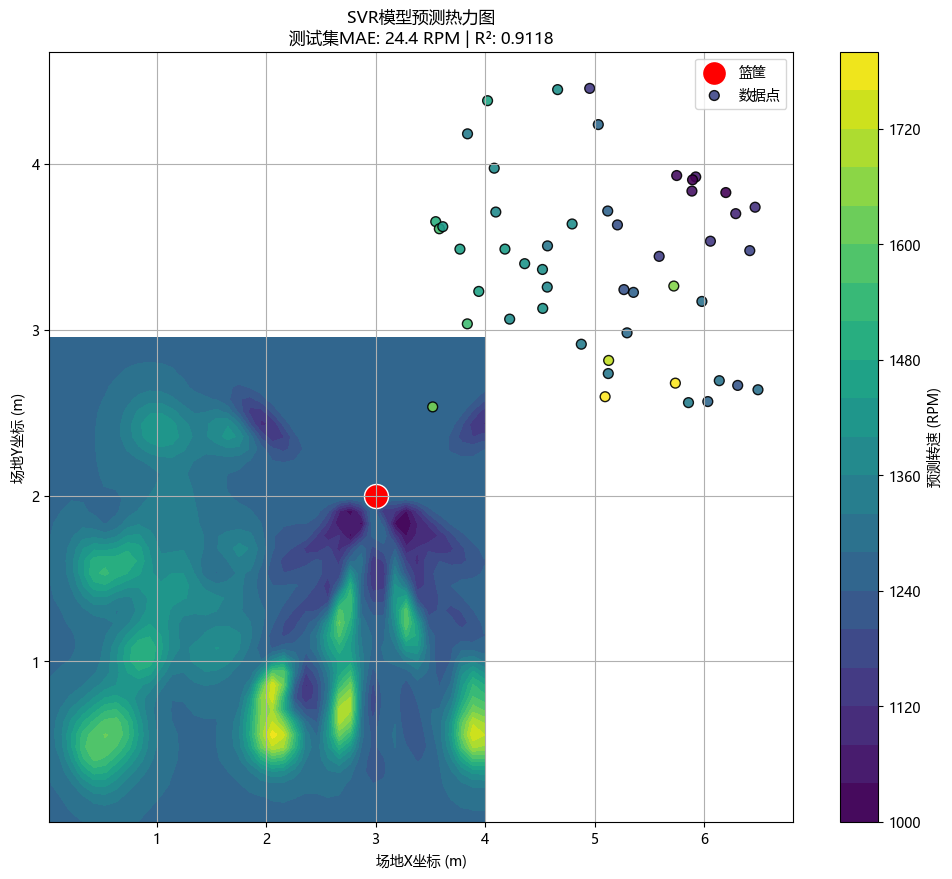

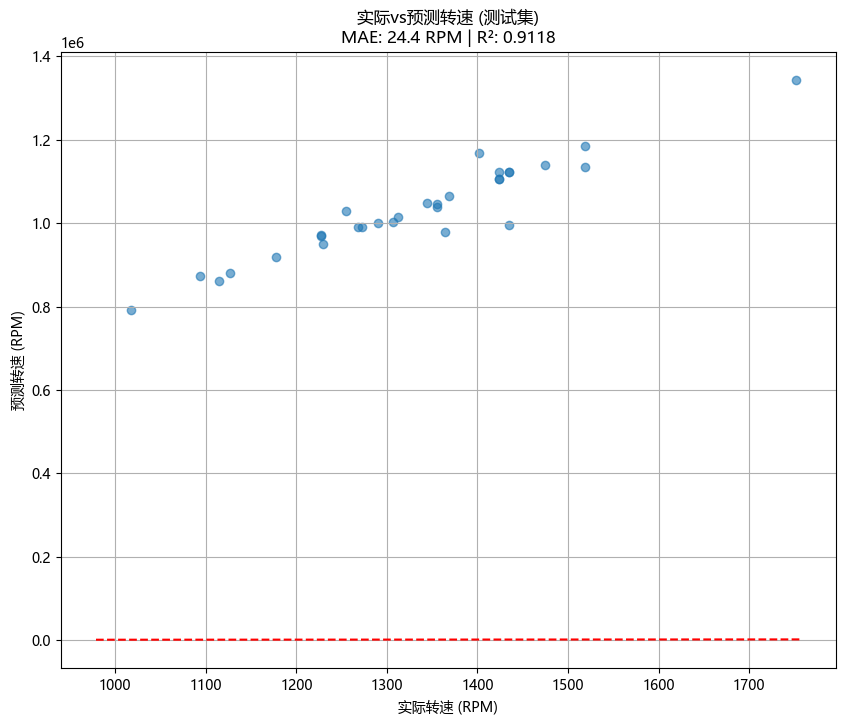

In [10]:
# ==================== 10. 可视化结果 ====================
def plot_hoop_coord_predictions(model, scaler, hoop_pos, Y_range, resolution=40):
    """在篮筐坐标系中可视化预测结果"""
    # 创建预测网格
    x_min, x_max = X_hoop[:,0].min()-0.5, X_hoop[:,0].max()+0.5
    y_min, y_max = X_hoop[:,1].min()-0.5, X_hoop[:,1].max()+0.5
    
    x_range = np.linspace(x_min, x_max, resolution)
    y_range = np.linspace(y_min, y_max, resolution)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # 添加极坐标特征
    grid_extended = add_polar_features(grid_points)
    
    # 归一化
    grid_norm = scaler.transform(grid_extended)
    
    # 预测
    pred_norm = model.predict(grid_norm)
    pred = pred_norm * (Y_range[1] - Y_range[0]) + Y_range[0]
    
    # 创建热力图
    plt.figure(figsize=(12, 10))
    contour = plt.contourf(
        xx + hoop_pos[0], yy + hoop_pos[1], 
        pred.reshape(xx.shape), 20, cmap='viridis'
    )
    
    # 添加篮筐位置
    plt.scatter(hoop_pos[0], hoop_pos[1], s=300, marker='o', 
                c='red', edgecolors='white', label='篮筐')
    
    # 添加原始数据点
    plt.scatter(
        X_clean[:, 0] + hoop_pos[0], 
        X_clean[:, 1] + hoop_pos[1], 
        c=Y_clean, cmap='viridis', s=50, alpha=0.9,
        edgecolors='k', label='数据点'
    )
    
    plt.colorbar(contour, label='预测转速 (RPM)')
    plt.xlabel('场地X坐标 (m)')
    plt.ylabel('场地Y坐标 (m)')
    plt.title(f'SVR模型预测热力图\n测试集MAE: {test_mae:.1f} RPM | R²: {test_r2:.4f}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 实际vs预测散点图
    plt.figure(figsize=(10, 8))
    y_test_denorm = y_test * (Y_range[1] - Y_range[0]) + Y_range[0]
    test_pred_denorm = test_pred * (Y_range[1] - Y_range[0]) + Y_range[0]
    
    plt.scatter(y_test_denorm, test_pred_denorm, alpha=0.6)
    plt.plot([Y_range[0], Y_range[1]], [Y_range[0], Y_range[1]], 'r--')
    plt.xlabel('实际转速 (RPM)')
    plt.ylabel('预测转速 (RPM)')
    plt.title(f'实际vs预测转速 (测试集)\nMAE: {test_mae:.1f} RPM | R²: {test_r2:.4f}')
    plt.grid(True)
    plt.show()

# 可视化预测热力图
plot_hoop_coord_predictions(svr_model, scaler, HOOP_POS, (Y_min, Y_max))


In [11]:
# ==================== 11. 嵌入式代码生成 ====================
def generate_svr_embedded_code(model, scaler, hoop_pos, Y_range, test_mae, test_r2):
    """生成SVR模型的C语言预测代码"""
    # 获取模型参数
    support_vectors = model.support_vectors_  # 修复：使用正确的变量名
    dual_coef = model.dual_coef_[0]
    intercept = model.intercept_[0]
    gamma = model.gamma
    
    # 格式化归一化参数
    feat_min_str = ', '.join([f'{x:.6f}f' for x in scaler.data_min_])
    feat_max_str = ', '.join([f'{x:.6f}f' for x in scaler.data_max_])
    
    # 格式化支持向量
    sv_lines = []
    for vec in support_vectors:  # 使用support_vectors变量
        vec_str = ', '.join([f'{val:.6f}f' for val in vec])
        sv_lines.append(f'    {{{vec_str}}}')
    sv_str = ',\n'.join(sv_lines)
    
    # 生成C代码
    code = f"""// ==================== 投篮机器人转速预测代码 (SVR模型) ====================
// 坐标系: 以篮筐为原点
// 篮筐位置: ({hoop_pos[0]:.2f}f, {hoop_pos[1]:.2f}f)
// 模型类型: RBF核支持向量回归
// 支持向量数: {len(support_vectors)}
// 测试集性能: 
//   MAE = {test_mae:.1f} RPM
//   R² = {test_r2:.4f}

#include <math.h>

// -------------------- 1. 归一化参数 --------------------
const float hoop_x = {hoop_pos[0]:.4f}f;
const float hoop_y = {hoop_pos[1]:.4f}f;

// 特征归一化范围 (训练时使用MinMaxScaler)
const float feat_min[{len(scaler.data_min_)}] = {{{feat_min_str}}};
const float feat_max[{len(scaler.data_max_)}] = {{{feat_max_str}}};

const float rpm_min = {Y_range[0]:.1f}f;
const float rpm_max = {Y_range[1]:.1f}f;

// -------------------- 2. SVR模型参数 --------------------
const float gamma = {gamma:.6f}f;  // RBF核参数
const float intercept = {intercept:.6f}f;

// 支持向量 (共{len(support_vectors)}个)
const float support_vectors[{len(support_vectors)}][{support_vectors.shape[1]}] = {{
{sv_str}
}};

// 对偶系数
const float dual_coefs[{len(dual_coef)}] = {{
    {', '.join([f'{coef:.6f}f' for coef in dual_coef])}
}};

// -------------------- 3. 辅助函数 --------------------
// RBF核函数
float rbf_kernel(const float* x1, const float* x2, int dim) {{
    float sum = 0.0f;
    for (int i = 0; i < dim; i++) {{
        float diff = x1[i] - x2[i];
        sum += diff * diff;
    }}
    return expf(-gamma * sum);
}}

// 特征归一化
void normalize_features(const float* input, float* output, int dim) {{
    for (int i = 0; i < dim; i++) {{
        output[i] = 2.0f * (input[i] - feat_min[i]) / (feat_max[i] - feat_min[i]) - 1.0f;
    }}
}}

// 添加极坐标特征
void add_polar_features(const float* point, float* features) {{
    // 原始特征 (x, y)
    features[0] = point[0];
    features[1] = point[1];
    
    // 计算极坐标
    float r = sqrtf(point[0]*point[0] + point[1]*point[1]);
    float theta = atan2f(point[1], point[0]);
    
    // 扩展特征
    features[2] = r;
    features[3] = theta;
    features[4] = sinf(theta);
    features[5] = cosf(theta);
    features[6] = sinf(2*theta);
    features[7] = cosf(2*theta);
    features[8] = r*r;
    features[9] = 1.0f / (r + 1e-6f);  // 避免除零
}}

// -------------------- 4. 预测函数 --------------------
float predict_rpm(float world_x, float world_y) {{
    // 1. 转换到篮筐坐标系
    float point[2] = {{
        world_x - hoop_x,
        world_y - hoop_y
    }};
    
    // 2. 计算特征 (包括极坐标)
    float raw_features[10];  // 确保与特征工程维度匹配
    add_polar_features(point, raw_features);
    
    // 3. 归一化特征
    float features[10];
    normalize_features(raw_features, features, 10);
    
    // 4. 计算SVR预测
    float sum = intercept;
    for (int i = 0; i < {len(support_vectors)}; i++) {{
        float k = rbf_kernel(features, support_vectors[i], 10);
        sum += dual_coefs[i] * k;
    }}
    
    // 5. 反归一化得到实际转速
    float rpm_norm = sum;
    float result = rpm_norm * (rpm_max - rpm_min) + rpm_min;
    
    // 6. 输出保护
    if (result < rpm_min) return rpm_min;
    if (result > rpm_max) return rpm_max;
    return result;
}}

// ==================== 使用示例 ====================
/*
#include <stdio.h>
#include <math.h>  // 对于cosf, sinf等函数

#define M_PI 3.14159265358979323846f

int main() {{
    // 测试点: 篮筐正前方2米处
    float x = hoop_x - 2.0f, y = hoop_y;
    float rpm = predict_rpm(x, y);
    printf("(%.1f, %.1f) -> %.1f RPM\\n", x, y, rpm);
    
    // 测试点: 篮筐右侧45度1.5米处
    x = hoop_x - 1.5f * cosf(M_PI/4);
    y = hoop_y + 1.5f * sinf(M_PI/4);
    rpm = predict_rpm(x, y);
    printf("(%.1f, %.1f) -> %.1f RPM\\n", x, y, rpm);
    
    return 0;
}}
*/"""
    return code

# 生成嵌入式代码
embedded_code = generate_svr_embedded_code(
    svr_model, scaler, HOOP_POS, (Y_min, Y_max), test_mae, test_r2
)

print("\n" + "="*80)
print("嵌入式C代码（SVR模型版）：")
print(embedded_code)
print("="*80)

# 保存代码到文件
output_file = "real_svr_hoop_predictor.c"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(embedded_code)
print(f"代码已保存到 {output_file}")


嵌入式C代码（SVR模型版）：
// ==================== 投篮机器人转速预测代码 (SVR模型) ====================
// 坐标系: 以篮筐为原点
// 篮筐位置: (3.00f, 2.00f)
// 模型类型: RBF核支持向量回归
// 支持向量数: 184
// 测试集性能: 
//   MAE = 24.4 RPM
//   R² = 0.9118

#include <math.h>

// -------------------- 1. 归一化参数 --------------------
const float hoop_x = 3.0000f;
const float hoop_y = 2.0000f;

// 特征归一化范围 (训练时使用MinMaxScaler)
const float feat_min[10] = {-2.602512f, -1.539317f, 0.080933f, -3.131037f, -0.999890f, -1.000000f, -0.999547f, -0.999559f, 0.006550f, 0.330724f};
const float feat_max[10] = {2.478583f, 0.476189f, 3.023668f, 3.141315f, 0.398154f, 0.999898f, 0.999858f, 1.000000f, 9.142568f, 12.355747f};

const float rpm_min = 978.8f;
const float rpm_max = 1756.8f;

// -------------------- 2. SVR模型参数 --------------------
const float gamma = 10.000000f;  // RBF核参数
const float intercept = 0.382917f;

// 支持向量 (共184个)
const float support_vectors[184][10] = {
    {-0.016015f, 0.342084f, -0.910126f, -0.662703f, -0.823370f, -0.481519f, 0.844168f, -0.

In [12]:
# ==================== 12. 部署建议 ====================
print("\n" + "="*50 + " 部署建议 " + "="*50)
print("1. SVR模型特点：")
support_vectors = svr_model.support_vectors_  # 获取支持向量
print(f"   - 支持向量数: {len(support_vectors)}")
print(f"   - 训练时间: 比岭回归长，但预测精度通常更高")

print("\n2. 模型性能分析：")
print(f"   - 测试集MAE: {test_mae:.1f} RPM")
print(f"   - 测试集R²: {test_r2:.4f}")

if test_mae > 100:
    print("\n警告：MAE > 100 RPM，建议：")
    print("  a) 增加训练样本量，特别是篮筐附近")
    print("  b) 调整SVR参数：增加C值或减小epsilon")
    print("  c) 检查数据质量，确保传感器校准正确")
else:
    print("\n模型精度满足要求，可直接部署")

print("\n3. 嵌入式部署注意事项：")
print("  - 确保MCU有足够内存存储支持向量")
memory_usage = len(support_vectors) * support_vectors.shape[1] * 4  # 使用已定义的support_vectors变量
print(f"    所需内存: {len(support_vectors)} 向量 × {support_vectors.shape[1]} 特征 × 4 字节 = {memory_usage} 字节")
print("  - 使用硬件浮点运算单元(FPU)加速计算")
print("  - 首次使用时校准篮筐位置")
print("  - 在真实环境中验证模型性能")


================================================== 部署建议 ==================================================
1. SVR模型特点：
   - 支持向量数: 167
   - 训练时间: 比岭回归长，但预测精度通常更高

2. 模型性能分析：
   - 测试集MAE: 77.8 RPM
   - 测试集R²: 0.9369

模型精度满足要求，可直接部署

3. 嵌入式部署注意事项：
  - 确保MCU有足够内存存储支持向量
    所需内存: 167 向量 × 10 特征 × 4 字节 = 6680 字节
  - 使用硬件浮点运算单元(FPU)加速计算
  - 首次使用时校准篮筐位置
  - 在真实环境中验证模型性能
